In [279]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [280]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=3):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# FUNÇÃO DE TRANSFERÊNCIA

In [281]:
s  = ctl.TransferFunction.s
G  = 4/(s * (s + 0.5))
G_bkp = G
G

TransferFunction(array([4]), array([1. , 0.5, 0. ]))

- Obtendo os polos e zeros da TF

In [282]:
zeros = ctl.zeros(G)
poles = ctl.poles(G)

print(zeros)
print(poles)

[]
[-0.5+0.j  0. +0.j]


- Resposta em degrau da TF

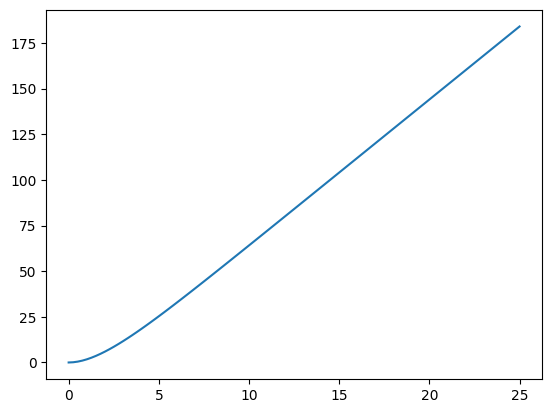

In [283]:
time, response = ctl.step_response(G)
plt.plot(time, response)

- Plotando o LGR e encontrando o polo desejado $s_d$ que estabelece os requisitos necessários

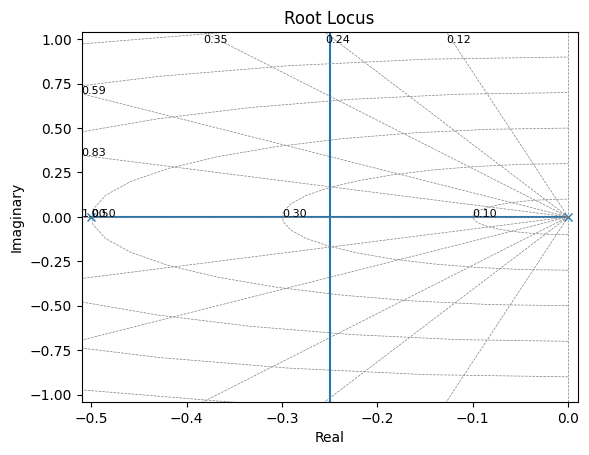

In [284]:
ctl.root_locus(G)
plt.show()

In [285]:
s_d = -2.5 + 4.33j
s_d

(-2.5+4.33j)

# CONTROLADOR LEAD

In [286]:
G = sympyFunction(G)
G

4/(1.0*s**2 + 0.5*s)

In [287]:
angle = float(sp.N(sp.arg(G.subs(s, s_d))))
angle

2.185280531609248

In [288]:
phi = angle - np.pi
phi

-0.9563121219805453

In [289]:
a = np.real(s_d) + np.imag(s_d)*np.tan(phi/2)
a

-4.744106402699158

In [290]:
b = np.real(s_d) + np.imag(s_d)*np.tan(3/2*phi)
b

-34.06458901330642

In [291]:
G_ma = G * (s - a)/(s - b)

K = 1/sp.Abs(G_ma.subs(s, s_d))
K = roundSympyFunction(sp.N(K))
K = float(K)
K

38.947021484375

In [292]:
s = ctl.TransferFunction.s
G = G_bkp

In [293]:
C = K * (s - a)/(s - b)
C

TransferFunction(array([ 38.94702148, 184.76881399]), array([ 1.        , 34.06458901]))

In [294]:
G_ma = G*C
G_ma

TransferFunction(array([155.78808594, 739.07525596]), array([ 1.        , 34.56458901, 17.03229451,  0.        ]))

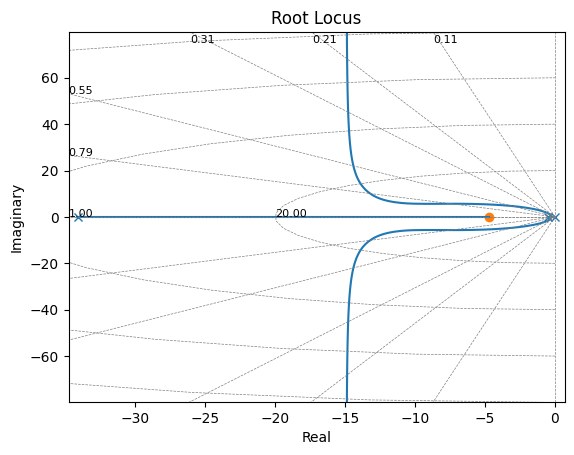

In [295]:
ctl.root_locus(G_ma)
plt.show()

In [296]:
print(sympyFunction(G_ma))

(155.7880859375*s + 739.07525596034)/(1.0*s**3 + 34.5645890133064*s**2 + 17.0322945066532*s)


In [297]:
T = ctl.feedback(G_ma, 1)
T

TransferFunction(array([155.78808594, 739.07525596]), array([  1.        ,  34.56458901, 172.82038044, 739.07525596]))

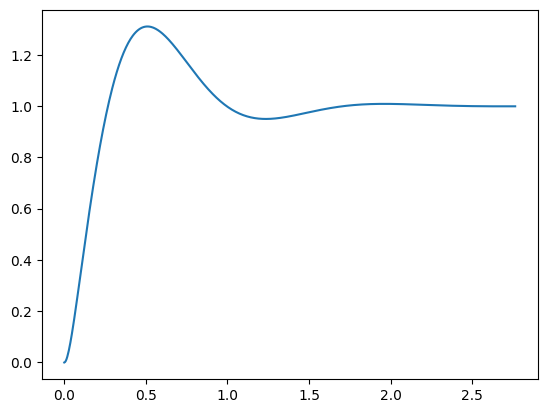

In [298]:
time, response = ctl.step_response(T)
plt.plot(time, response)

# CONTROLADOR LAG

In [299]:
G     = G_ma
G_bkp = G
G = sympyFunction(G)
G

(155.7880859375*s + 739.07525596034)/(1.0*s**3 + 34.5645890133064*s**2 + 17.0322945066532*s)

In [300]:
Kp = G.subs(s, 0.000000000001)
Kp

43392583170182.8

- $e_{ss} = \frac{1}{1 + k_p} \Rightarrow k_p = \frac{1}{e_{ss}} - 1$

In [301]:
min_error = 0.1

In [302]:
    K_desired = 1/min_error - 1
    K_desired

9.0

In [303]:
K_lag = abs(K_desired/Kp)
K_lag

2.07408716939082e-13

In [304]:
a = float(sp.re(s_d) * 1/9)
a

-0.2777777777777778

In [305]:
b = float(a/K_lag)
b

-1339277258338.9744

In [306]:
C = (s - a)/(s - b)
C

(s + 0.277777777777778)/(s + 1339277258338.97)

In [307]:
s = ctl.TransferFunction.s
G = G_bkp
C = (s - a)/(s - b)

G_ma = G*C
T = ctl.feedback(G_ma, 1)

print(sympyFunction(T)) 
T

(155.7880859375*s**2 + 782.349724276313*s + 205.298682211206)/(1.0*s**4 + 1339277258373.54*s**3 + 46291568009527.3*s**2 + 22810964690874.8*s + 205.298682211206)


TransferFunction(array([155.78808594, 782.34972428, 205.29868221]), array([1.00000000e+00, 1.33927726e+12, 4.62915680e+13, 2.28109647e+13,
       2.05298682e+02]))

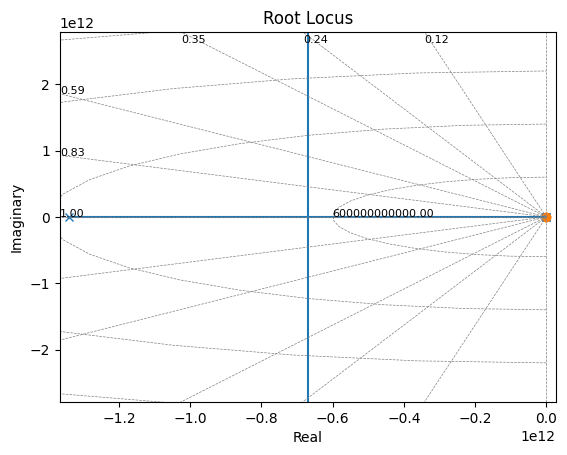

In [308]:
ctl.root_locus(G_ma)
plt.show()

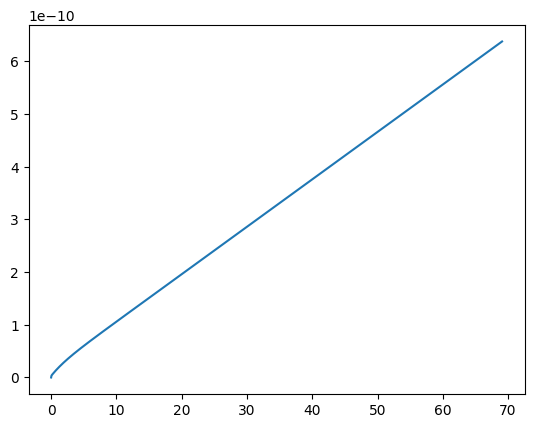

In [309]:
time, response = ctl.step_response(T)
plt.plot(time, response)